In [1]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *

sys.path.append('../3_score/')
from optimize import Scores

Found 19 grids
Found 19 ligands
Loading crystal structures...
Loading docking results...
Loading glidescores...
64 of 361 ligand, structure pairs failed to dock.
Loading rmsds...
All ligands successfully fingerprinted. Nice!
Found 19 grids
Found 19 ligands
Loading crystal structures...
Loading docking results...
Loading glidescores...
64 of 361 ligand, structure pairs failed to dock.
Loading rmsds...
All ligands successfully fingerprinted. Nice!


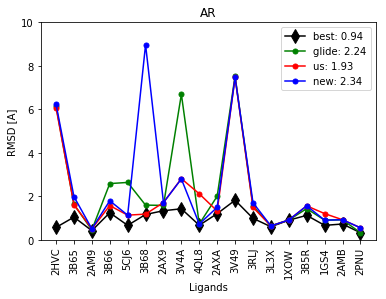

Found 13 grids
Found 13 ligands
Loading crystal structures...
Loading docking results...
Loading glidescores...
All ligands and structures successfully docked. Nice!
Loading rmsds...
All ligands successfully fingerprinted. Nice!
Found 13 grids
Found 13 ligands
Loading crystal structures...
Loading docking results...
Loading glidescores...
All ligands and structures successfully docked. Nice!
Loading rmsds...
All ligands successfully fingerprinted. Nice!


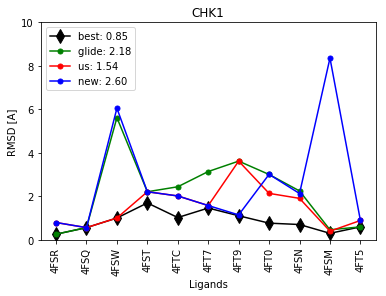

In [2]:
get_ipython().magic(u'matplotlib inline')
datasets = ['AR','CHK1']#['AR', 'B2AR', 'CDK2','HSP90','LPXC','TRMD', 'CHK1']

for receptor in datasets:

    data_set_dir = '/scratch/PI/rondror/docking_data/'+receptor+'/'
   
    rmsd_file = 'rmsd.csv'
    ligands_dir = data_set_dir + 'ligands/'
    grids_dir = data_set_dir + 'grids/'
    glide_dir = data_set_dir + 'glide/'
    crystal_fp_file = data_set_dir + 'crystal_ifp_july5/ifp.fp'
    docking_fp_dir = data_set_dir + 'glide_ifp_july5/'

    crystal_fp_file2 = data_set_dir + 'crystal_ifp_july8/ifp.fp'
    docking_fp_dir2 = data_set_dir + 'glide_ifp_july8/'
    
    (crystals, glides) = load_data(
        data_set_dir, rmsd_file, ligands_dir, grids_dir, glide_dir, crystal_fp_file, docking_fp_dir)

    (crystals2, glides2) = load_data(
        data_set_dir, rmsd_file, ligands_dir, grids_dir, glide_dir, crystal_fp_file2, docking_fp_dir2)
    
    max_num_poses = 50
    best_rmsd_matrix = best_pose(glides, max_num_poses)
    
    rmsd_filter = lambda x: x < 2
    best_structure, filtered_ligands, ave_rmsd = get_structure_and_ligands(best_rmsd_matrix, rmsd_filter, glides.keys())

    scores = Scores(glides, crystals, filtered_ligands, best_structure, max_num_poses)
    scores2 = Scores(glides2, crystals2, filtered_ligands, best_structure, max_num_poses)
    
    final_rmsds = plot_final_rmsds(scores,receptor,scores2,'new: ')
    #plot_magnitudes(scores2, receptor)